<a href="https://colab.research.google.com/github/rybak97/SR_cartoon/blob/main/SRCNN_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

from scipy import signal
from scipy import ndimage

from matplotlib import pyplot as plt

import math

import cv2 as cv
import numpy as np

import os

Szczytowy stosunek sygnału do szumu, rzadziej stosunek sygnału szczytowego do szumu (PSNR, ang. peak signal-to-noise ratio) – stosunek maksymalnej mocy sygnału do mocy szumu zakłócającego ten sygnał. Ze względu na szeroki zakres wartości PSNR wyrażany jest w decybelach.

PSNR jest przybliżeniem ludzkiej percepcji jakości rekonstrukcji.

W przypadku braku szumu oba obrazy są identyczne, a zatem MSE wynosi zero. W tym przypadku PSNR jest nieskończony

In [2]:
def psnr(target, ref):
         
    target_data = target.astype(float)
    ref_data = ref.astype(float)

    diff = ref_data - target_data
    diff = diff.flatten('C')

    rmse = math.sqrt(np.mean(diff ** 2.))

    return 20 * math.log10(1. / rmse)

SSIM służy do pomiaru podobieństwa między dwoma obrazami. Pomiar jakości obrazu opiera się na pozbawionym zniekształceń obrazie jako wzorcu. Wskaźnik podobieństwa strukturalnego (SSIM) wyodrębnia 3 kluczowe cechy obrazu:
jasność, kontrast, struktura.

In [3]:
def ssim(img1, img2):
    C1 = (0.01 * 1)**2
    C2 = (0.03 * 1)**2

    img1 = img1.astype(np.float64)
    img2 = img2.astype(np.float64)
    kernel = cv.getGaussianKernel(3, 1.5)
    window = np.outer(kernel, kernel.transpose())

    mu1 = cv.filter2D(img1, -1, window)[3:-3, 3:-3]  # valid
    mu2 = cv.filter2D(img2, -1, window)[3:-3, 3:-3]
    mu1_sq = mu1**2
    mu2_sq = mu2**2
    mu1_mu2 = mu1 * mu2
    sigma1_sq = cv.filter2D(img1**2, -1, window)[3:-3, 3:-3] - mu1_sq
    sigma2_sq = cv.filter2D(img2**2, -1, window)[3:-3, 3:-3] - mu2_sq
    sigma12 = cv.filter2D(img1 * img2, -1, window)[3:-3, 3:-3] - mu1_mu2

    ssim_map = ((2 * mu1_mu2 + C1) * (2 * sigma12 + C2)) / ((mu1_sq + mu2_sq + C1) *
                                                            (sigma1_sq + sigma2_sq + C2))
    return ssim_map.mean()


def calculate_ssim(img1, img2):

    if img1.ndim == 3:
        if img1.shape[2] == 3:
            ssims = []
            for i in range(3):
                ssims.append(ssim(img1, img2))
            return np.array(ssims).mean()


https://arxiv.org/pdf/1501.00092.pdf

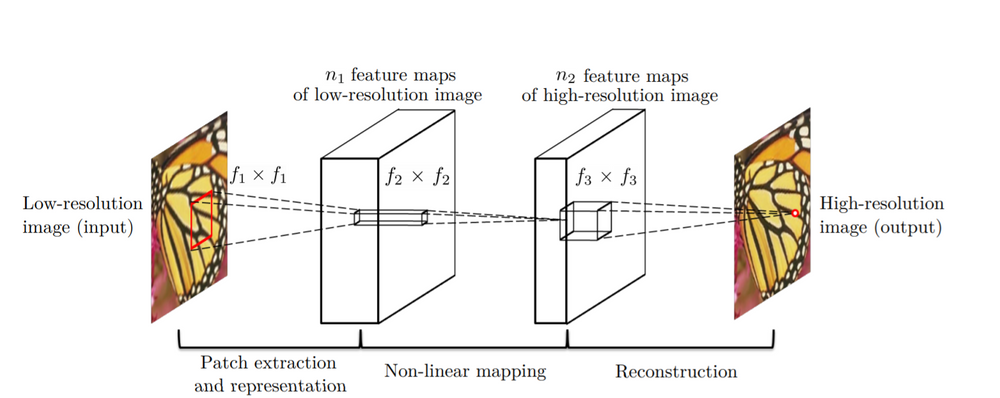

struktura sieci: 

warstwa pierwsza: operacja wyodrębnia część obrazu Y o niskiej rozdzielczości i przedstawia każdą łatkę jako
wektor wielowymiarowy. 

warstwa druga: operacja nieliniowa
mapuje każdy wysokowymiarowy wektor na inny
wektor wielowymiarowy. 

warstwa trzecia: rekonstrukcja, ta operacja agreguje łaty
aby wygenerować ostateczny obraz w wysokiej rozdzielczości.

In [4]:
inputs = keras.Input(shape=(128, 128, 3), name='img')

x = layers.Conv2D(
    filters=64,             
    kernel_size=9,          
    padding='same',         
    activation=tf.nn.relu   
)(inputs)

x = layers.Conv2D(
    filters=32,      
    kernel_size=1,
    padding='same',  
    activation=tf.nn.relu
)(x)

outputs = layers.Conv2D(
    filters=3,
    kernel_size=5,          
    padding='same'          
)(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='SRCNN_model')
  
model.summary() 

Model: "SRCNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 128, 128, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 128, 128, 64)      15616     
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      2080      
                                                                 
 conv2d_2 (Conv2D)           (None, 128, 128, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


Test działania na zbiorze cifar-10

Obraz LR- startowy cifar-10 o obniżonej jakości interpolacja „najbliższego sąsiada” 

Obraz GT- startowy cifar-10 

In [5]:
ishape = 128

(train_images, train_labels), (test_images, test_labels) = tf.keras.datasets.cifar10.load_data()


train_image = train_images[0:5000]
test_image  = test_images[0:500]


X_train = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape), interpolation=cv.INTER_NEAREST) for i in test_image]) / 255.

y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.

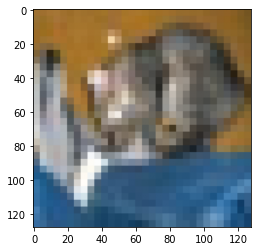

In [6]:
plt.imshow(X_test[0])

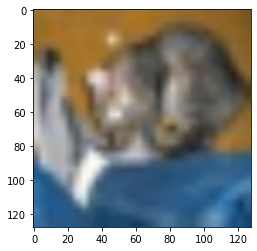

In [7]:
plt.imshow(y_test[0])

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       
              metrics=['mae'])    

history = model.fit(X_train, y_train,
                    batch_size=64,
                    epochs=3,
                    validation_split=0.2)

test_scores = model.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

model.save('SRCNN.h5')

Epoch 1/3
63/63 [==============================] - 20s 229ms/step - loss: 0.6106 - mae: 0.2784 - val_loss: 0.0125 - val_mae: 0.0718
Epoch 2/3
63/63 [==============================] - 12s 184ms/step - loss: 0.0116 - mae: 0.0710 - val_loss: 0.0099 - val_mae: 0.0653
Epoch 3/3
63/63 [==============================] - 12s 183ms/step - loss: 0.0088 - mae: 0.0603 - val_loss: 0.0063 - val_mae: 0.0483
16/16 - 1s - loss: 0.0065 - mae: 0.0493 - 1s/epoch - 65ms/step
Test loss: 0.006531907245516777
Test mae: 0.04930287227034569


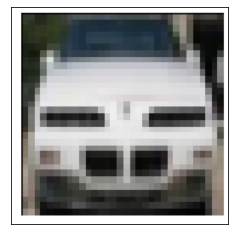

In [9]:
ishape = 128

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Test na obrazie testowym

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


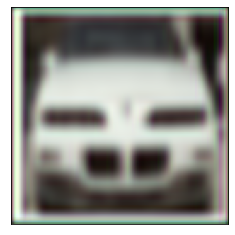

In [11]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.


img_SR = model.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

Obliczenie PSNR

In [12]:
psnr(img,img_SR)

14.880876034440124

In [13]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([14.880876], shape=(1,), dtype=float32)


Obliczanie SSIM

In [14]:
img_own = np.reshape(img,(128,128,3))
img_SR_own = np.reshape(img_SR,(128,128,3))

In [15]:
z = calculate_ssim(img_own,img_SR_own)
print(z)

0.5659310641622691


In [16]:
img = tf.reshape(img, [128,128,3,1])

img_SR = tf.reshape(img_SR, [128,128,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.5305268


In [17]:
#### RR ##################

Test działania na zbiorze pokemon (809 obrazów)

Obraz LR- obraz o jakości obniżonej blurem

Obraz GT- startowy obraz

In [18]:
inputs = keras.Input(shape=(120, 120, 3), name='img')

x = layers.Conv2D(
    filters=64,             
    kernel_size=9,          
    padding='same',         
    activation=tf.nn.relu   
)(inputs)

x = layers.Conv2D(
    filters=32,      
    kernel_size=1,
    padding='same',  
    activation=tf.nn.relu
)(x)

outputs = layers.Conv2D(
    filters=3,
    kernel_size=5,          
    padding='same'          
)(x)

model2 = keras.Model(inputs=inputs, outputs=outputs, name='SRCNN_model')
  
model2.summary() 

Model: "SRCNN_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, 120, 120, 3)]     0         
                                                                 
 conv2d_3 (Conv2D)           (None, 120, 120, 64)      15616     
                                                                 
 conv2d_4 (Conv2D)           (None, 120, 120, 32)      2080      
                                                                 
 conv2d_5 (Conv2D)           (None, 120, 120, 3)       2403      
                                                                 
Total params: 20,099
Trainable params: 20,099
Non-trainable params: 0
_________________________________________________________________


In [19]:
images = []


for file in os.listdir('/content/drive/MyDrive/images/'):
    images.append(cv.imread('/content/drive/MyDrive/images/{}'.format(file)))

In [20]:
ishape = 120

train_image = images[0:647]
test_image  = images[647:]

train_image2 = images[0:647] #czyste
test_image2  = images[647:]



for i in range(np.asarray(647)):

  
  train_image[i] = cv.blur(train_image[i],(7,7))
 


for i in range(np.asarray(809-647)):

  
  test_image[i] = cv.blur(test_image[i],(7,7))
 

X_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image]) / 255.
X_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image]) / 255.


y_train = np.array([cv.resize(i,(ishape,ishape)) for i in train_image2]) / 255.
y_test  = np.array([cv.resize(i,(ishape,ishape)) for i in test_image2]) / 255.

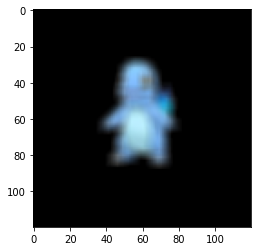

In [21]:
plt.imshow(X_test[77])

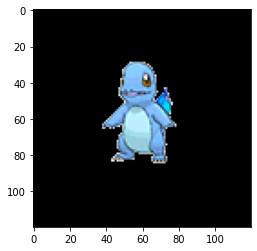

In [22]:
plt.imshow(y_test[77])

In [23]:
model2.compile(optimizer=tf.keras.optimizers.Adam(0.01),
              loss='mse',       
              metrics=['mae'])    

history = model2.fit(X_train, y_train,
                    batch_size=32,
                    epochs=30,
                    validation_split=0.2)

test_scores = model2.evaluate(X_test, y_test, verbose=2) 

print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])

model2.save('SRCNN_2.h5')

Epoch 1/30
17/17 [==============================] - 4s 115ms/step - loss: 1.4376 - mae: 0.2889 - val_loss: 0.1024 - val_mae: 0.1404
Epoch 2/30
17/17 [==============================] - 1s 84ms/step - loss: 0.0477 - mae: 0.1002 - val_loss: 0.0306 - val_mae: 0.0822
Epoch 3/30
17/17 [==============================] - 1s 84ms/step - loss: 0.0195 - mae: 0.0652 - val_loss: 0.0152 - val_mae: 0.0565
Epoch 4/30
17/17 [==============================] - 1s 84ms/step - loss: 0.0136 - mae: 0.0516 - val_loss: 0.0130 - val_mae: 0.0472
Epoch 5/30
17/17 [==============================] - 1s 84ms/step - loss: 0.0131 - mae: 0.0497 - val_loss: 0.0180 - val_mae: 0.0654
Epoch 6/30
17/17 [==============================] - 1s 84ms/step - loss: 0.0167 - mae: 0.0603 - val_loss: 0.0122 - val_mae: 0.0476
Epoch 7/30
17/17 [==============================] - 1s 83ms/step - loss: 0.0153 - mae: 0.0571 - val_loss: 0.0123 - val_mae: 0.0485
Epoch 8/30
17/17 [==============================] - 1s 82ms/step - loss: 0.0126 - 

Test na obrazie testowym

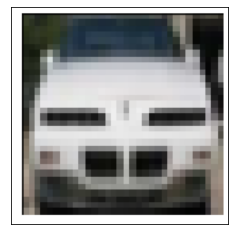

In [24]:
ishape = 120

img = cv.imread('/content/drive/MyDrive/bmw.png')

img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

img = cv.resize(img,(ishape,ishape), interpolation=cv.INTER_NEAREST)

plt.imshow(img)

plt.xticks([]), plt.yticks([])

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


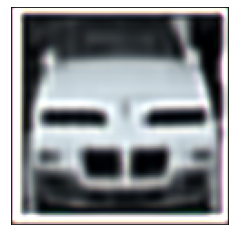

In [25]:
img = np.reshape(img,(1,ishape,ishape,3)) / 255.

img_SR = model2.predict(img)

plt.imshow(img_SR[0])

plt.xticks([]), plt.yticks([])

plt.show()

Obliczenie PSNR

In [26]:
psnr(img,img_SR)

17.287664627922453

In [27]:
psnr1 = tf.image.psnr(img, img_SR, max_val=1)
print(psnr1)

tf.Tensor([17.287664], shape=(1,), dtype=float32)


SSIM

In [28]:
img_own = np.reshape(img,(120,120,3))
img_SR_own = np.reshape(img_SR,(120,120,3))

In [29]:
z = calculate_ssim(img_own,img_SR_own)
print(z)

0.5738350788460271


In [30]:
img = tf.reshape(img, [120,120,3,1])

img_SR = tf.reshape(img_SR, [120,120,3,1])

img = tf.image.convert_image_dtype(img, tf.float32)
img_SR = tf.image.convert_image_dtype(img_SR, tf.float32)

ssim1 = tf.image.ssim(img, img_SR, max_val=1, filter_size=3,
                          filter_sigma=1.5, k1=0.01, k2=0.03)
print(np.mean(ssim1))

0.46479568


Porównanie wizualne uzyskanych wyników (od góry: SR cifar, SR pokemon, LR test)


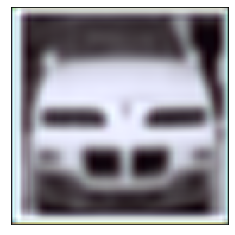

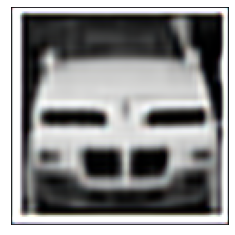
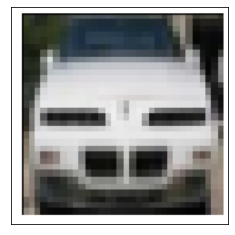

Wnioski:

1. Sieć SRCNN została zbudowana w prawidłowy sposób z wykorzystaniem artykułu twórców.

2. Czas nauki sieci jest krótki (80s dla obu sieci), w przypadku nauki na zbiorze cifar-10 sieć zużywa prawie 10GB Ramu, sieć pokemon 3GB.

3. Miara PSNR w dobry sposób odwzorowuje ludzki sposób precepcji jakości. SR pokemon jest wizualnie lepszej jakości od SR cifar 10. Warto rozważyć dodanie współczynnika SSIM w celu oceny jakość obrazów SR pod względem innych kryterium.


